Friday US SP500 Movements vs Monday SP500 ETF Movement in JPY

In [1]:
from tiportfolio.helpers.data import Alpaca
import dotenv

dotenv.load_dotenv()

import os
alpaca = Alpaca(os.environ['ALPACA_API_KEY'], os.environ['ALPACA_API_SECRET'])

In [6]:
from tiportfolio.helpers.data import YFinance
yfinance = YFinance()

In [ ]:
# get spy
spy_df = yfinance.query('SPY', '2020-01-01', '2024-12-31', '1D', 'all')
spy_df

In [ ]:
# get 2558.T
etf_jp_df = yfinance.query('2558.T', '2018-01-01', '2024-12-31', '1D', 'all')
etf_jp_df

Get close from each, and merge them together, since they have different trading days, we do an outer join.

3 Columns to keep:
- date (as index)
- spy_adj_close
- etf_jp_adj_close
- spy_open
- etf_jp_open

In [ ]:
import pandas as pd

# select required columns (assumes 'adj_close' column exists from YFinance with auto_adjust=False)
spy_sel = spy_df[['date', 'open', 'adj_close']].copy()
etf_sel = etf_jp_df[['date', 'open', 'adj_close']].copy()

# rename columns to identify source
spy_sel.rename(columns={'adj_close': 'spy_adj_close', 'open': 'spy_open'}, inplace=True)
etf_sel.rename(columns={'adj_close': 'etf_jp_adj_close', 'open': 'etf_jp_open'}, inplace=True)

# outer join on the date column (dates are ISO-local strings per notebook comment)
merged = pd.merge(spy_sel, etf_sel, on='date', how='outer')

# coerce price columns to numeric to ensure consistent dtypes
price_cols = ['spy_adj_close', 'etf_jp_adj_close', 'spy_open', 'etf_jp_open']
for col in price_cols:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

# set date as index and sort
merged = merged.set_index('date').sort_index()

# quick sanity output
print(f"Merged rows: {len(merged)}")
print("Missing values per column:")
print(merged[price_cols].isna().sum())

# show the first few rows
merged

In [ ]:
# calculate (close - open) / open for spy and etf_jp of each row
merged['spy_return'] = (merged['spy_adj_close'] - merged['spy_open']) / merged['spy_open']
merged['etf_jp_return'] = (merged['etf_jp_adj_close'] - merged['etf_jp_open']) / merged['etf_jp_open']
merged

Now we want to find the relation between each Friday, US SPY Close - Open return vs next Monday (or next non NaN day in etf_jp columns), Japan ETF Close - Open return.

In [26]:
# Pair each Friday SPY return with the next non-NaN JP ETF return (check up to 3 market rows ahead)
import numpy as np
import matplotlib.pyplot as plt
import os

# defensive copy
_df = merged.copy()

# ensure datetime index for weekday operations
_df.index = pd.to_datetime(_df.index)

# compute returns if not already present
if 'spy_return' not in _df.columns:
    _df['spy_return'] = (_df['spy_adj_close'] - _df['spy_open']) / _df['spy_open']
if 'etf_jp_return' not in _df.columns:
    _df['etf_jp_return'] = (_df['etf_jp_adj_close'] - _df['etf_jp_open']) / _df['etf_jp_open']

# reset index so we can use positional lookups
_reset = _df.reset_index().rename(columns={'index': 'date'})

pairs = []
N = len(_reset)

for i, row in _reset.iterrows():
    # only Fridays
    if row['date'].weekday() != 4:
        continue
    # require spy return
    if pd.isna(row.get('spy_return')):
        continue

    matched = None
    # check next 1..3 rows for first non-NaN etf_jp_return
    for ahead in range(1, 4):
        j = i + ahead
        if j >= N:
            break
        candidate = _reset.at[j, 'etf_jp_return']
        if not pd.isna(candidate):
            matched = {
                'friday_date': row['date'].date().isoformat(),
                'spy_friday_return': float(row['spy_return']),
                'etf_matched_date': _reset.at[j, 'date'].date().isoformat(),
                'etf_next_return': float(candidate),
                'rows_ahead': ahead,
            }
            break
    if matched is not None:
        pairs.append(matched)

pairs_df = pd.DataFrame(pairs)

print(f"Total Fridays considered: {_reset['date'].dt.weekday.eq(4).sum()}")
print(f"Total Fridays matched: {len(pairs_df)}")


pairs_df

Total Fridays considered: 260
Total Fridays matched: 250


,friday_date,spy_friday_return,etf_matched_date,etf_next_return,rows_ahead
0,2020-01-03,-0.077351,2020-01-07,-0.058838,2
1,2020-01-10,-0.085366,2020-01-14,-0.060650,2
2,2020-01-17,-0.080236,2020-01-20,-0.062413,1
3,2020-01-24,-0.091075,2020-01-27,-0.071569,1
4,2020-01-31,-0.095741,2020-02-03,-0.062547,1
...,...,...,...,...,...
245,2024-11-29,-0.007250,2024-12-02,-0.012953,1
246,2024-12-06,-0.011410,2024-12-09,-0.009118,1
247,2024-12-13,-0.015580,2024-12-16,-0.008202,1
248,2024-12-20,0.007297,2024-12-23,-0.007839,1



SPY Friday return summary:
count    250.000000
mean      -0.043588
std        0.023094
min       -0.127860
25%       -0.062006
50%       -0.043668
75%       -0.023629
max        0.007297
Name: spy_friday_return, dtype: float64

ETF next return summary:
count    250.000000
mean      -0.038192
std        0.016526
min       -0.116792
25%       -0.050391
50%       -0.039004
75%       -0.025404
max       -0.007576
Name: etf_next_return, dtype: float64

Pearson correlation: 0.8271
Linear fit: etf_next_return = 0.591837 * spy_friday_return + -1.239540e-02


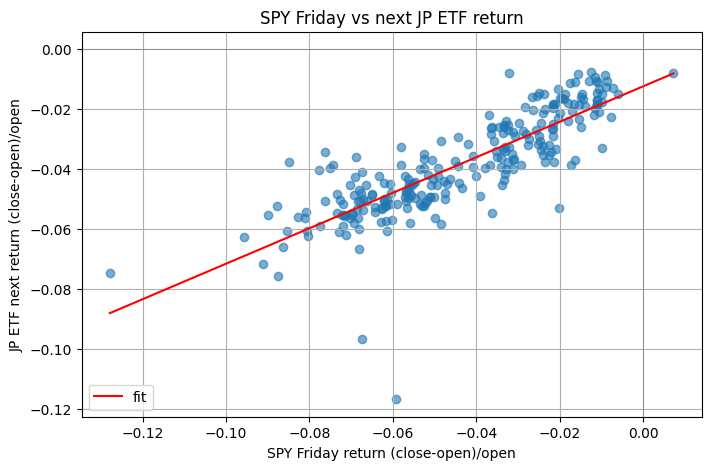

Saved pairs CSV to: /Users/tim/Development/TiPortfolio/research/friday_spy_vs_next_etf_pairs.csv


In [27]:

if pairs_df.empty:
    print("No matched pairs found. Inspect `merged` to ensure ETF JP data exists after Fridays.")
else:
    # basic summaries
    print('\nSPY Friday return summary:')
    print(pairs_df['spy_friday_return'].describe())
    print('\nETF next return summary:')
    print(pairs_df['etf_next_return'].describe())

    # correlation
    corr = pairs_df['spy_friday_return'].corr(pairs_df['etf_next_return'])
    print(f"\nPearson correlation: {corr:.4f}")

    # linear fit (OLS slope/intercept)
    x = pairs_df['spy_friday_return'].values
    y = pairs_df['etf_next_return'].values
    slope, intercept = np.polyfit(x, y, 1)
    print(f"Linear fit: etf_next_return = {slope:.6f} * spy_friday_return + {intercept:.6e}")

    # scatter plot with fit line
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, alpha=0.6)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, slope * xs + intercept, color='red', label='fit')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('SPY Friday return (close-open)/open')
    plt.ylabel('JP ETF next return (close-open)/open')
    plt.title('SPY Friday vs next JP ETF return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # save the pairs to CSV in the current working directory
    out_path = os.path.join(os.getcwd(), 'friday_spy_vs_next_etf_pairs.csv')
    pairs_df.to_csv(out_path, index=False)
    print(f"Saved pairs CSV to: {out_path}")